# 0. Imports

In [ ]:
import argparse
from functools import partial
import json
import os
from typing import Callable
from pathlib import Path
import pickle

import flax
import flax.linen as nn
from flax.training.train_state import TrainState
from jax.flatten_util import ravel_pytree
from jax import vmap
import jax.numpy as jnp
from jax.tree_util import tree_map
import jax.random as jr
import optax

import demos.collas.datasets.dataloaders as dataloaders
import rebayes.utils.models as models
import rebayes.utils.callbacks as callbacks
import rebayes.sgd_filter.sgd as sgd
import demos.collas.hparam_tune as hparam_tune
import demos.collas.train_utils as train_utils
import demos.collas.run_classification_experiments as experiments

In [ ]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

# 1. Set Up MLP Model

## 1.1 Fashion-MNIST

In [ ]:
dataset = dataloaders.clf_datasets["stationary"]
dataset_load_fn, kwargs = dataset(ntrain=2000).values()
dataset_load_fn = partial(dataset_load_fn, dataset_type="fashion_mnist")
eval_metric = experiments._eval_metric("stationary", "nll", 1.0, 1.0)

In [ ]:
model_init_fn = partial(models.initialize_classification_mlp,
                        hidden_dims=[500,] * 2)
model_init_fn_probe = partial(models.initialize_classification_mlp,
                              hidden_dims=[500,] * 2, capture_intermediates=True)

In [ ]:
input_dim, output_dim = experiments._compute_io_dims("stationary", "fashion_mnist")
model_init_fn = partial(model_init_fn, input_dim=input_dim,
                        output_dim=output_dim)
model_init_fn_probe = partial(model_init_fn_probe, input_dim=input_dim,
                              output_dim=output_dim)

In [ ]:
agents = experiments._process_agent_args(["sgd-rb",], "diagonal", False,
                                         [10,], input_dim, output_dim, 
                                         "stationary", "nll", 2)

In [ ]:
output_path = Path("../collas/classification", "outputs", "stationary",
                    "fashion_mnist_split", "mlp", "nll")
Path(output_path).mkdir(parents=True, exist_ok=True)

In [ ]:
config_path = Path("../collas/classification", "configs")
hparam_path = Path(config_path, "stationary", "fashion_mnist", "mlp", "nll")

## 1.2 CIFAR-10

In [238]:
dataset = dataloaders.clf_datasets["stationary"]
dataset_load_fn, kwargs = dataset(ntrain=10_000).values()
dataset_load_fn = partial(dataset_load_fn, dataset_type="cifar10")
eval_metric = experiments._eval_metric("stationary", "nll", 1.0, 1.0)

model_init_fn = partial(models.initialize_classification_mlp,
                        hidden_dims=[100,] * 10)
model_init_fn_probe = partial(models.initialize_classification_mlp,
                              hidden_dims=[100,] * 10, capture_intermediates=True)

In [239]:
input_dim, output_dim = experiments._compute_io_dims("stationary", "cifar10")
model_init_fn = partial(model_init_fn, input_dim=input_dim,
                        output_dim=output_dim)
model_init_fn_probe = partial(model_init_fn_probe, input_dim=input_dim,
                              output_dim=output_dim)

In [240]:
agents = experiments._process_agent_args(["sgd-rb",], "diagonal", False,
                                         [10,], input_dim, output_dim, 
                                         "stationary", "nll", 2)

In [242]:
output_path = Path("../collas/classification", "outputs", "stationary",
                    "cifar10_10k_split", "dnn", "nll")
Path(output_path).mkdir(parents=True, exist_ok=True)

In [243]:
config_path = Path("../collas/classification", "configs")
hparam_path = Path(config_path, "stationary", "cifar10_10k", "dnn", "nll")

## 1.3 Common

In [244]:
agent_hparams = {}
for agent_name in agents:
    # Check if hyperparameters are specified in config file
    agent_hparam_path = Path(hparam_path, agent_name+".json")
    try:
        # Load json file
        with open(agent_hparam_path, "r") as f:
            agent_hparams[agent_name] = json.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"Hyperparameter {agent_hparam_path} "
                                "not found.")


In [245]:
for agent_name, hparams in agent_hparams.items():
    print(f"Evaluating {agent_name}...")
    agent_kwargs = agents[agent_name]
    if "pbounds" in agent_kwargs:
        agent_kwargs.pop("pbounds")
    optimizer_dict = hparam_tune.build_estimator(model_init_fn, hparams,
                                                 agent_name, 
                                                 classification=True, 
                                                 **agent_kwargs)

Evaluating sgd-rb-10...


# 2. Stitching Helper Functions

In [ ]:
def generate_sub_networks(model_init_fn, flat_params, layer_start=0, layer_end=-1):
    params_dict = model_init_fn(0)["unflatten_fn"](flat_params)
    model = model_init_fn(0)["model"]
    features, activation = model.features, model.activation
    if layer_end == -1 or layer_end >= len(features):
        layer_end = len(features)
        activation = lambda x: x
    if layer_start > len(features):
        raise ValueError(f"layer_start must be less than {len(features)}")
    if layer_end < layer_start:
        raise ValueError(f"layer_end must be greater than layer_start")
    model.features = features[layer_start:layer_end]
    if layer_start == 0:
        input_dim, *_ = params_dict["Dense_0"]["kernel"].shape
    else:
        input_dim = features[layer_start - 1]
    params = {
        f"Dense_{i-layer_start}": 
            params_dict[f"Dense_{i}"] for i in range(layer_start, layer_end)
    }
    params = flax.core.frozen_dict.freeze(params)
    apply_fn = lambda x: activation(model.apply({"params": params}, x))
    
    sub_model_dict = {
        "model": model,
        "params": params,
        "apply_fn": apply_fn,
        "activation": activation,
        "input_dim": input_dim,
        "output_dim": features[layer_end - 1],
    }
    
    return sub_model_dict

In [ ]:
def get_trained_params(key):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    agent, init_cov = optimizer_dict["agent"], optimizer_dict["init_cov"]
    keys = jr.split(key)
    dataset = dataset_load_fn(key=keys[0])
    model = model_init_fn(keys[1])
    X_train, *_, y_train = dataset["train"]
    X_test, *_, y_test = dataset["test"]
    
    test_kwargs = {"agent": agent, "X_test": X_test, "y_test": y_test,
                   "apply_fn": model["apply_fn"], "key": key, **kwargs}
    
    bel, result = agent.scan(model["flat_params"], init_cov, X_train, y_train,
                             callback=eval_metric["test"], **test_kwargs)
    
    return bel, result

In [ ]:
def construct_linear_stitching(model1, model2, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    input_dim, output_dim = model1["output_dim"], model2["input_dim"]
    
    # Construct linear stitching
    linear_model = models.MLP(features=[output_dim,], activation=lambda x: x)
    params = linear_model.init(key, jnp.ones(input_dim))['params']
    apply_fn = lambda w, x: linear_model.apply({"params": w}, x)
    linear_model_dict = {
        "model": linear_model,
        "apply_fn": apply_fn,
        "params": params,
    }
    
    return linear_model_dict

In [ ]:
def train_linear_stitching(model1, model2, dataset_load_fn,
                           num_epochs=10, batch_size=64,
                           learning_rate=1e-2, key=0, eval_at_end=True,
                           loss_fn=optax.softmax_cross_entropy):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    keys = jr.split(key, 3)
    dataset = dataset_load_fn(key=keys[0])
    X, *_, y = dataset["train"]
    X_test, *_, y_test = dataset["test"]
    if eval_at_end:
        X_test, y_test = None, None
    linear_model = construct_linear_stitching(model1, model2, keys[1])
    params = linear_model["params"]
    tx = optax.sgd(learning_rate=learning_rate)
    opt_state = tx.init(params)
    train_state = TrainState(
        step=0, apply_fn=linear_model["apply_fn"],
        params=params, tx=tx, opt_state=opt_state,
    )
    def linear_layer_loss(params, x, y, apply_fn):
        input = vmap(model1["apply_fn"])(x)
        linear_output = vmap(apply_fn, (None, 0))(params, input)
        output = vmap(model2["apply_fn"])(linear_output)
        loss = jnp.mean(loss_fn(output, y))
        
        return loss
    
    state, losses = sgd.train_full(
        key=keys[2], num_epochs=num_epochs, batch_size=batch_size,
        state=train_state, X=X, y=y, loss=linear_layer_loss,
        X_test=X_test, y_test=y_test,
    )
    num_batches = X.shape[0] // batch_size
    losses["train"] /= num_batches
    
    return state, losses

In [222]:
def construct_stitched_model(model1, model2, linear_model, linear_train_state):
    def apply_fn(input):
        intermediate_output1 = model1["apply_fn"](input)
        intermediate_output2 = linear_model["apply_fn"](
            linear_train_state.params, intermediate_output1
        )
        output = model2["apply_fn"](intermediate_output2)
        
        return output
    
    return {"apply_fn": apply_fn}

# 3. Experiments

In [231]:
dataset = dataset_load_fn(key=0)
X_test, *_, y_test = dataset["test"]

## 3.1 Stitch Random Networks (Control)

In [232]:
random_network = model_init_fn(0)
control_model1 = generate_sub_networks(model_init_fn, random_network["flat_params"], layer_end=1)
control_model2 = generate_sub_networks(model_init_fn, random_network["flat_params"], layer_start=1)

In [233]:
control_linear_model = construct_linear_stitching(control_model1, control_model2)

In [234]:
control_state, control_losses = train_linear_stitching(control_model1, control_model2, 
                                                       dataset_load_fn, num_epochs=1000, 
                                                       learning_rate=1e-2)

In [236]:
control_stitched_model = construct_stitched_model(control_model1, control_model2, control_linear_model, control_state)

In [237]:
control_stitched_predictions = vmap(control_stitched_model["apply_fn"])(X_test)
control_stitched_predictions = jnp.argmax(control_stitched_predictions, axis=-1)
control_stitched_miscl = jnp.mean(control_stitched_predictions != y_test)
print(f"Stitched model misclassification rate: {control_stitched_miscl:.3f}")

Stitched model misclassification rate: 0.192


## 3.2: Stitch Two Random Initializations (SGD-10)

In [ ]:
bel1, result1 = get_trained_params(0)
bel2, result2 = get_trained_params(1)

In [203]:
# Baseline test misclassification
baseline_model = model_init_fn(key=0)
baseline_predictions = vmap(baseline_model["apply_fn"], (None, 0))(bel1.params, X_test)
baseline_predictions = jnp.argmax(baseline_predictions, axis=1)
baseline_miscl = jnp.mean(baseline_predictions != y_test)
print(f"Baseline test misclassification: {baseline_miscl:.3f}")

Baseline test misclassification: 0.206


In [204]:
model1 = generate_sub_networks(model_init_fn, bel1.params, layer_end=1)
model2 = generate_sub_networks(model_init_fn, bel2.params, layer_start=1)

In [207]:
linear_model = construct_linear_stitching(model1, model2)

In [215]:
state, losses = train_linear_stitching(model1, model2, dataset_load_fn,
                                       num_epochs=1000, learning_rate=1e-2)

In [223]:
stitched_model = construct_stitched_model(model1, model2, linear_model, state)

In [230]:
stitched_predictions = vmap(stitched_model["apply_fn"])(X_test)
stitched_predictions = jnp.argmax(stitched_predictions, axis=-1)
stitched_miscl = jnp.mean(stitched_predictions != y_test)
print(f"Stitched model misclassification rate: {stitched_miscl:.3f}")

Stitched model misclassification rate: 0.168


# 4. CIFAR

In [246]:
dataset = dataset_load_fn(key=0)
X_test, *_, y_test = dataset["test"]

## Control

In [247]:
random_network = model_init_fn(0)
control_model1 = generate_sub_networks(model_init_fn, random_network["flat_params"], layer_end=1)
control_model2 = generate_sub_networks(model_init_fn, random_network["flat_params"], layer_start=1)

In [248]:
control_linear_model = construct_linear_stitching(control_model1, control_model2)

In [257]:
control_state, control_losses = train_linear_stitching(control_model1, control_model2, 
                                                       dataset_load_fn, num_epochs=1000,
                                                       learning_rate=1e-2)
control_stitched_model = construct_stitched_model(control_model1, control_model2, control_linear_model, control_state)

In [258]:
control_stitched_predictions = vmap(control_stitched_model["apply_fn"])(X_test)
control_stitched_predictions = jnp.argmax(control_stitched_predictions, axis=-1)
control_stitched_miscl = jnp.mean(control_stitched_predictions != y_test)
print(f"Stitched model misclassification rate: {control_stitched_miscl:.3f}")

Stitched model misclassification rate: 0.840


## Random Initializations

In [252]:
bel1, result1 = get_trained_params(0)
bel2, result2 = get_trained_params(1)

In [253]:
# Baseline test misclassification
baseline_model = model_init_fn(key=0)
baseline_predictions = vmap(baseline_model["apply_fn"], (None, 0))(bel1.params, X_test)
baseline_predictions = jnp.argmax(baseline_predictions, axis=1)
baseline_miscl = jnp.mean(baseline_predictions != y_test)
print(f"Baseline test misclassification: {baseline_miscl:.3f}")

Baseline test misclassification: 0.776


In [254]:
model1 = generate_sub_networks(model_init_fn, bel1.params, layer_end=1)
model2 = generate_sub_networks(model_init_fn, bel2.params, layer_start=1)

linear_model = construct_linear_stitching(model1, model2)

state, losses = train_linear_stitching(model1, model2, dataset_load_fn,
                                       num_epochs=1000, learning_rate=1e-2)

In [255]:
stitched_model = construct_stitched_model(model1, model2, linear_model, state)

In [256]:
stitched_predictions = vmap(stitched_model["apply_fn"])(X_test)
stitched_predictions = jnp.argmax(stitched_predictions, axis=-1)
stitched_miscl = jnp.mean(stitched_predictions != y_test)
print(f"Stitched model misclassification rate: {stitched_miscl:.3f}")

Stitched model misclassification rate: 0.672


# Bayesian Glue

In [10]:
import jax.random as jr
import matplotlib.pyplot as plt

import rebayes.datasets.datasets as dataset

In [15]:
train, test = dataset.load_1d_synthetic_dataset(trenches=True)

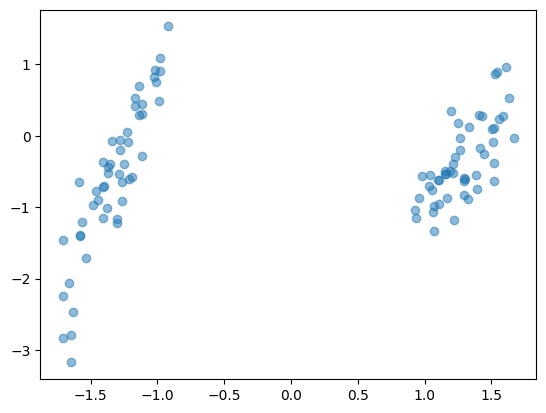

In [16]:
X_train, y_train = train

plt.scatter(X_train, y_train, alpha=0.5);